# DSC 170 Final Project: An Analysis of United States Housing

Team member names:
- Jayson Leach (A16469391)
- Sheena Patel (A16641602)

# Questions addressed:

We want to identify locations in the US that are most suitable for homebuyers, which we are likely to be in the near future. Where is it most affordable to live? What areas are likely to increase in price over the next few years? What areas have a low ratio of housing cost to income?

As stated above, the expected audience is future homebuyers with plans on relocating. This is for recent college graduates and people early into their career. Additionally, it could be used by those generally looking to relocate within the US. This is beneficial, because it can provide sets of potential locations filtered by different sets of important criteria. 

(250 words)

## Background and literature:
First, we plan to conduct our data exploration to find regions that may be preferred to live for homebuyers and check our findings and dive deep through online census comparisons. If we find certain concentrations of things such as crime rates, we want to utilize sources online to explain why crime may or may not be higher in those regions and provide justification to our findings. 

Here are some source we could begin with (subject to change depending on our project results): 
- https://www.census.gov/quickfacts/fact/table/CA,US/RHI225222 
- https://www.census.gov/library/visualizations/interactive/monthly-state-retail-sales.html 

(200 words)

Before selecting our data, we relied on articles, like [this from Money Crashers](https://www.moneycrashers.com/where-should-i-live-decide-best-places/), to inform us on what criteria homebuyers use when searching for places to live. This helped us identify factors like climate, crime, commute times, and education quality in addition to the logical financial incentives like job opportunities, housing cost, cost of living, etc. Though some of these factors did not make it into our analyses, it did help us narrow our search on what data is relevant.

By professor recommendation, we investigated existing data analysis by [Redfin](https://www.redfin.com/news/data-center/). This investigation led us to consider entirely new factors. Redfin has extensive data on job opportunities and provides job opportunity scores to metropolitan areas by the field of work. Additionally, they also have data on market competitiveness, which is something we did not consider. Some places have more people looking to buy homes than others. Our investigation of Redfin housing market data allowed us to see the vast number of directions we could take this project.

## Python libraries or ArcGIS modules
- GeoPandas / Pandas: Enables manipulation and analysis of dataframes and geospatial data.
- ArcGIS: Allows interaction with spatial data and leveraging the powerful geoprocessing tools of ArcGIS for in-depth analysis.

(100 words)

In [1]:
# imports
import pandas as pd
import numpy as np
import os
import geopandas 
from geopandas.tools import geocode
import getpass
import geopy
import geopandas as gpd
from shapely.geometry import Point
from arcgis.gis import GIS
from arcgis import features
from arcgis.features import FeatureLayer, FeatureSet
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import cenpy
import time

# warnings
import warnings
warnings.filterwarnings('ignore')

In [26]:
# GIS login
gis = GIS("https://ucsdonline.maps.arcgis.com/home", username='dsc170wi24_29', password='Nanu262!')

# Data Cleaning

Describe the cleaning/wrangling operations that you performed, and whether you realized you needed to clean the data by examining metadata documents or by introspecting the data itself. Was the amount of cleaning/data preparation similar to what you expected when writing project proposal?
Organize the discussion and code as a combination of markdown and code cells.
(100 words)

### Data Sources

- [Esri Updated Demographics Variables 2023](https://ucsdonline.maps.arcgis.com/home/item.html?id=ddd1510ed1964e2e8fb1ded93e9b03b1): This dataset contains over 150 popular demographic metrics by areas as small as census tracts. We plan to use metrics such as Housing Affordability Index, Unemployment Rate, Median Home Value, among others.
- [World Historical Climate Monthly Averages 1981-2010](https://ucsdonline.maps.arcgis.com/home/item.html?id=ed59d3b4a8c44100914458dd722f054f): This dataset contains the average monthly temperature over 30 years at various locations globally.
- [Mean Commute Time by State 2022](https://www.census.gov/csrm/comparisons/sorted-list.html): This dataset by the US Census contains the mean travel time to work in minutes by state from 2022.

### Get Esri Demographics  2023 data
> dem_gdf

<Item title:"Esri Updated Demographics Variables 2023" type:Feature Layer Collection owner:esri_demographics>
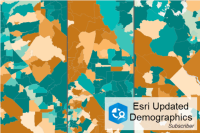

In [3]:
# Get Esri Demographic Variables 2023
dem_id = 'ddd1510ed1964e2e8fb1ded93e9b03b1'
dem = gis.content.get(dem_id)
display(dem)

start_time = time.time()
# Access the feature layer at county level for efficiency reasons
dem_layer = dem.layers[3]
dem_sdf = dem_layer.query().sdf
# Convert sdf to geodataframe
dem_gdf = geopandas.GeoDataFrame(dem_sdf, geometry= dem_sdf['SHAPE'], crs="EPSG:3857")
# Change crs for better visuals
dem_gdf = dem_gdf.to_crs('epsg:4326')

# Elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

# Display row
dem_gdf.head(1)

### Get Historical Temperature Averages Data
>  temp_gdf

<Item title:"World Historical Climate - Monthly Averages for GHCN-D Stations for 1981 - 2010" type:Feature Layer Collection owner:esri_observations>
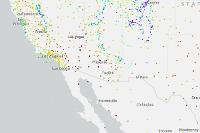

In [6]:
# Get Historical Temperature Averages
temp_id = 'ed59d3b4a8c44100914458dd722f054f'
temp = gis.content.get(temp_id)
display(temp)

# Access the feature layer
temp_layer = temp.layers[0]
temp_sdf = temp_layer.query().sdf

# Convert to geodataframe
temp_gdf = geopandas.GeoDataFrame(temp_sdf, geometry= temp_sdf['SHAPE'], crs="EPSG:4326")
# Filter irrelevant measurement points
temp_gdf = gpd.sjoin(temp_gdf, dem_gdf[['geometry']], how="inner", op="intersects").drop(columns=['index_right'])

# Display row
temp_gdf.head(1)

In [ ]:
# Calculate the yearly average Fahrenheit temperature 
temp_gdf['Year_TAVG_F'] = temp_gdf[['Jan_TAVG_F', 'Feb_TAVG_F', 'Mar_TAVG_F', 'Apr_TAVG_F', 'May_TAVG_F',
                                    'Jun_TAVG_F', 'Jul_TAVG_F', 'Aug_TAVG_F', 'Sep_TAVG_F', 'Oct_TAVG_F',
                                    'Nov_TAVG_F', 'Dec_TAVG_F']].mean(axis=1)
start_time = time.time()
# get the nearest temperature point
def mean_temp_calc(dem):
    distances = temp_gdf.distance(dem.geometry).sort_values()
    nearest_point = temp_gdf.loc[distances.index[0]]
    return nearest_point.Year_TAVG_F
# assign point to county projections
dem_gdf['Year_TAVG_F'] = dem_gdf.apply(mean_temp_calc, axis=1)
# elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

In [67]:
# # Get Esri Demographic Variables 2023
# crime_id = '57c2ca4a3dae4135b2f54736f331af70'
# crime = gis.content.get(crime_id)
# display(crime)

# start_time = time.time()
# # Access the feature layer at county level for efficiency reasons
# crime_layer = crime.layers[0]
# crime_sdf = crime_layer.query().sdf
# # Convert sdf to geodataframe
# crime_gdf = geopandas.GeoDataFrame(crime_sdf, geometry= crime_sdf['SHAPE'], crs="EPSG:3857")
# # Change crs for better visuals
# crime_gdf = crime_gdf.to_crs('epsg:4326')

# # Elapsed time
# end_time = time.time()
# elapsed_time = end_time - start_time
# print("Elapsed time:", elapsed_time, "seconds")

# # Display row
# crime_gdf.head(1)

## Descriptive Statistics

Explore the data using maps, charts, and common descriptive statistics. Sample questions you can try to answer: is there spatial autocorrelation in the data? Are you dealing with random point patterns? What is the spatial mean and standard distance? Or why the above questions are not relevant to your research theme and the data?
(a combination of markdown and documented code cells)

Let's identify some variables of interest within the Esri Demographics Spatial DataFrame.
- '**Year_TAVG_F**': Self-designed variable of aggregated monthly climate in Fahrenheit to visualize county level
    - This variable will help us identify warm climate regions in the US as well as regions with polarized climate (too hot or too cold) 
- '**VACANT_CY**': An estimate of the number of vacant homes. Vacancy is defined as no one living in the home or occupied entirely by temporary occupants who have usual residence in a different locations. This will be transformed into the percentage of vacant homes by divifing by the total number of homes (TOTHU_CY) to account for differing housing densities.
    - This variable is interesting, because it can be used to gauge the level of home availability. Low vacancy could indicate a competitive housing market.
- '**HAI_CY**': Housing Affordability Index. HAI values greater than 100 indicate increasing affordability; HAI values less than 100 indicate areas where homes are less affordable and median income might be insufficient to purchase a median-valued home. This will be transformed by normalization.
    - This variable is key, because it can be used to gauge whether homes are affordable which is the main target of our investigation.
- '**UNEMPRT_CY'**: An estimate of the unemployment rate of population age 16+. This will be transformed by normalization.
    - This variable is interesting, because it could be a good indicator for wealth and job availability in a specific geographic area. It is also a good tell for the state of the economy in said area.
- '**PCIGRWCYFY**': An estimate for the Per Capita Income Annual Growth Rate between 2023 and 2028. This will be transformed by normalization.
    - This variable is interesting, because it forecasts economic growth for the future. Buying a home is an investment, so choosing a location with a growing economy is important for home value.

### Exploring Warm Weather Regions in the US

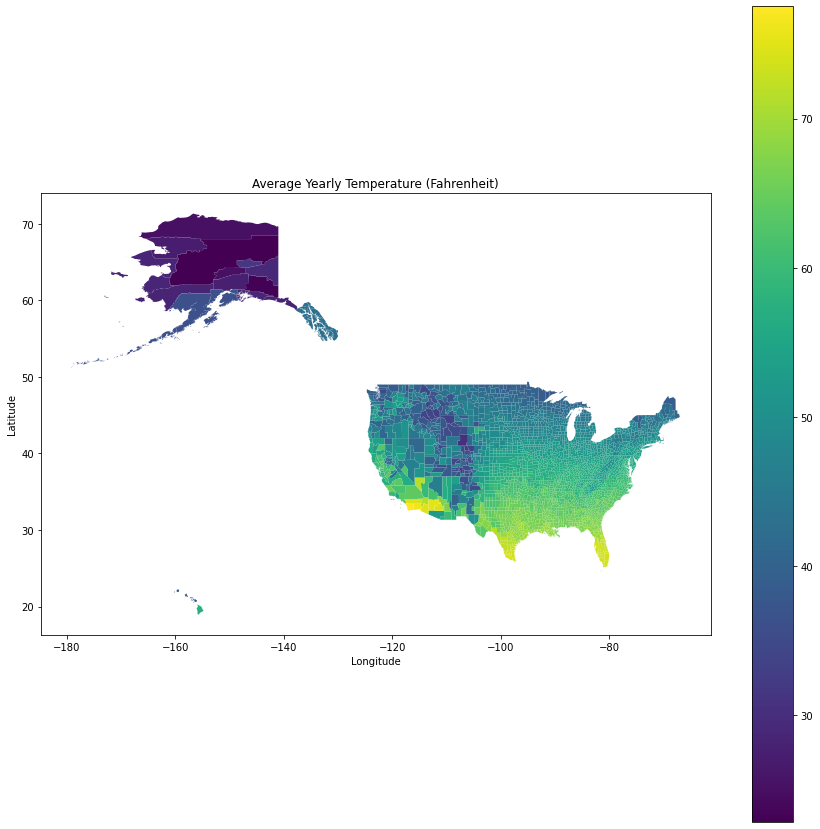

In [36]:
dem_gdf.plot(figsize=(15, 15), column='Year_TAVG_F', legend=True)
plt.title('Average Yearly Temperature (Fahrenheit)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

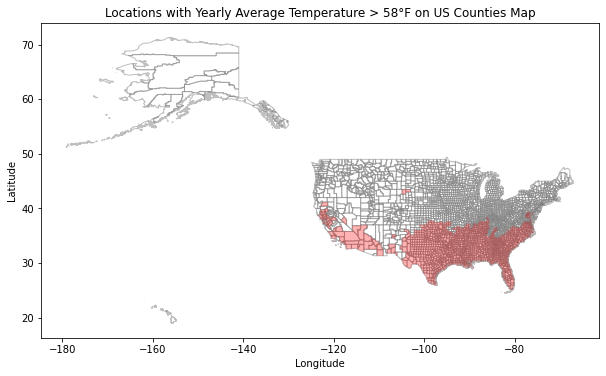

In [110]:
# Define warm locations as average yearly temperature > 58 degrees Fahrenheit
dem_gdf['focus_climate'] = dem_gdf.Year_TAVG_F > 58

# Filter locations where 'Year_TAVG_F' > 58
focus_climate = dem_gdf[dem_gdf['Year_TAVG_F'] > 58]
# Plot all US counties
fig, ax = plt.subplots(figsize=(10, 10))
dem_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.5)
# Plot locations with war weather in orange
focus_climate.plot(ax=ax, color='red', alpha=0.3)

plt.title('Locations with Yearly Average Temperature > 58°F on US Counties Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

 Highlights:
 - **Focus Region**: Southern bordering regions known as the "Sunbelt" have the warmest weather (65-75 degrees)
 - In contrast, Northern regions have the coldest average temperaates (40-45 degrees) 

## Exploring Affordability in the US

<AxesSubplot:ylabel='Frequency'>

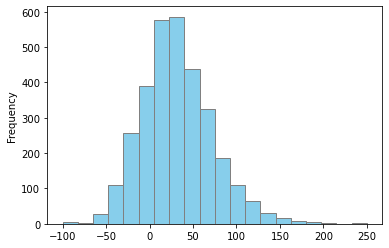

In [46]:
# Determine bins
dem_gdf['HAI_CY'].plot.hist(bins=20, color='skyblue', edgecolor='grey')

In [12]:
# Change so negative is less affordable and positive is more affordable
dem_gdf['HAI_CY'] = dem_gdf.HAI_CY.apply(float) - 100
# Adding binary HAI
dem_gdf['HAI_B'] = dem_gdf.HAI_CY > 0

In [58]:
dem_gdf.HAI_CY.mean()

31.485523385300667

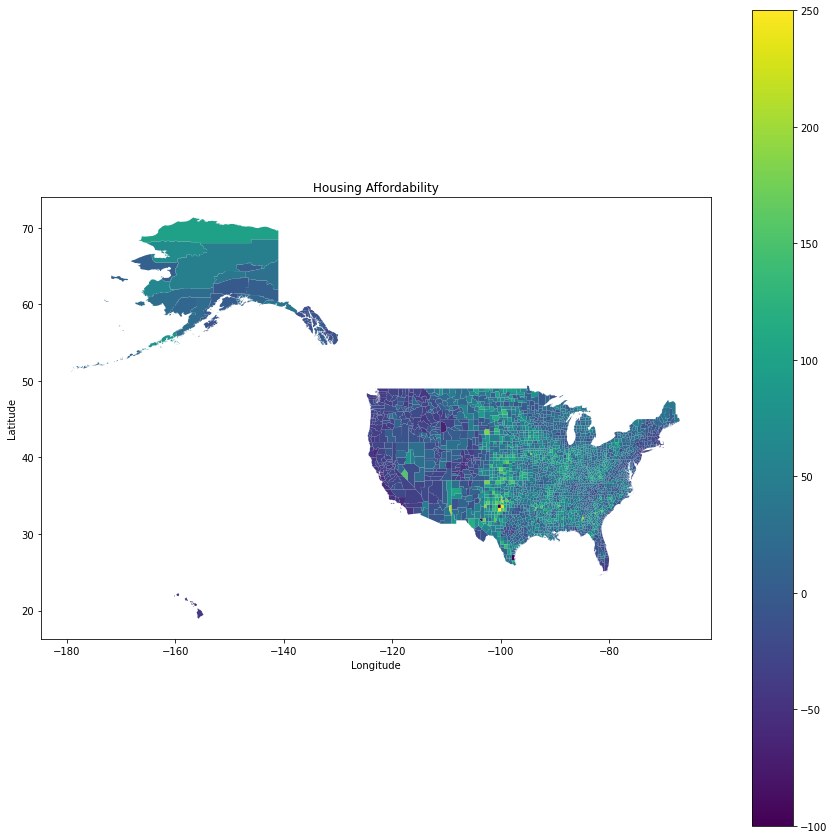

In [53]:
dem_gdf.plot(figsize=(15, 15), column='HAI_CY', legend=True)
plt.title('Housing Affordability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

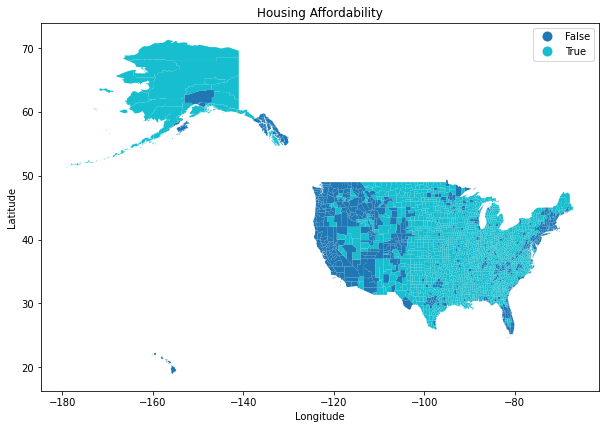

In [54]:
dem_gdf.plot(figsize=(10, 10), column='HAI_B', legend=True)
plt.title('Housing Affordability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

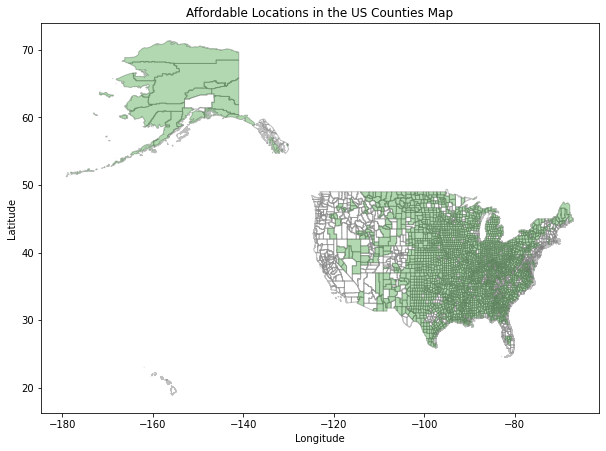

In [57]:
# Define regions with high affordability
dem_gdf['focus_afford'] = dem_gdf['HAI_B'] == True

# Filter locations where 'HAI_B' is TRUE
focus_afford = dem_gdf[dem_gdf['HAI_B']]

# Plot all US counties
fig, ax = plt.subplots(figsize=(10, 10))
dem_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.5)

# Plot locations with focus_affordability in green
focus_afford.plot(ax=ax, color='green', alpha=0.3)

plt.title('Affordable Locations in the US Counties Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Observations
- **Focus**: Midle and Eastern States in the US are most affordable
- West Coast States are least affordable

## Exploring Vacanacy in the US

In [71]:
# Designed vacancy percentage variable for analysis
dem_gdf['VACANT_PCT'] = (dem_gdf.VACANT_CY / dem_gdf.TOTHU_CY).apply(float)

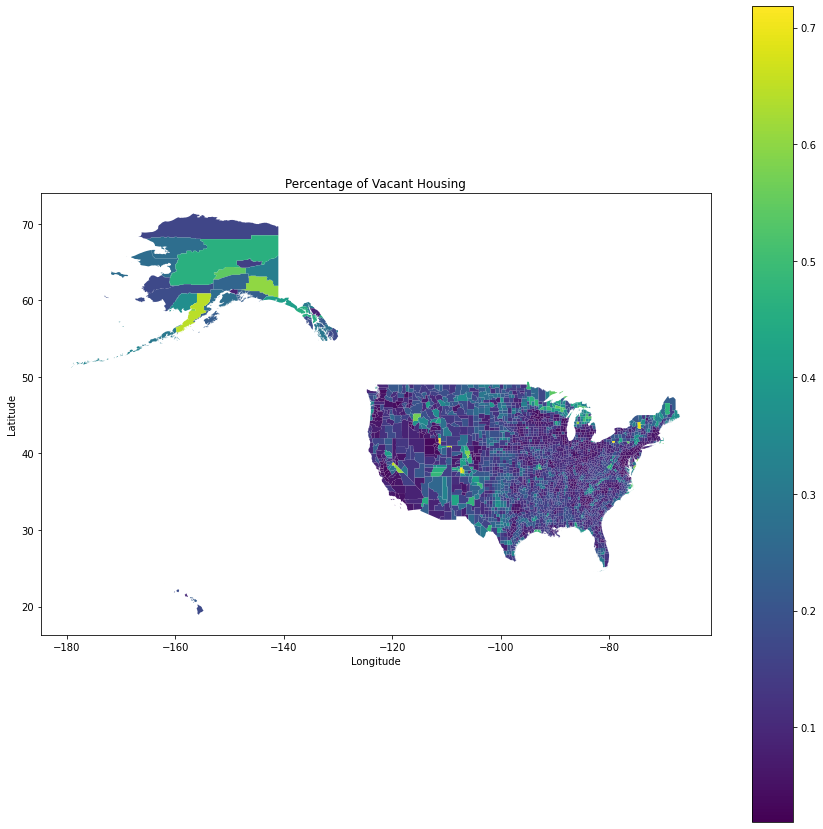

In [87]:
dem_gdf.plot(figsize=(15, 15), column='VACANT_PCT', legend=True)
plt.title('Percentage of Vacant Housing')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<AxesSubplot:ylabel='Frequency'>

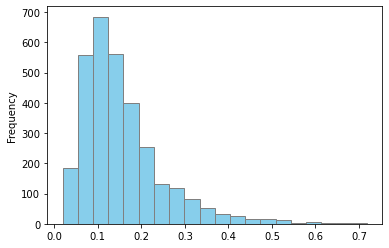

In [77]:
# Determine vacancy bins
dem_gdf['VACANT_PCT'].plot.hist(bins=20, color='purple', edgecolor='grey')

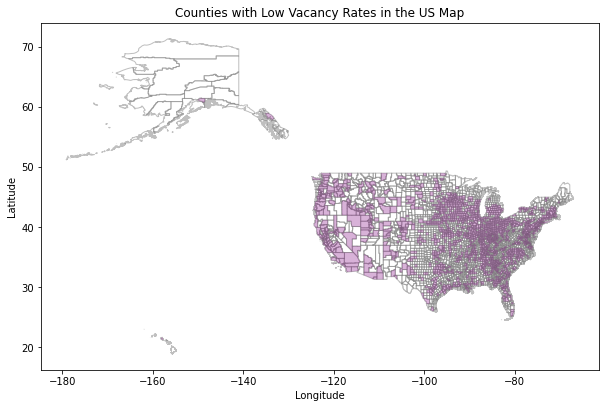

In [89]:
# Define regions with low vacancy rate as preferred
dem_gdf['focus_vacancy'] = dem_gdf['VACANT_PCT'] < dem_gdf['VACANT_PCT'].median()

# Filter locations where 'HAI_B' is TRUE
focus_vacancy = dem_gdf[dem_gdf['focus_vacancy']]

# Plot all US counties
fig, ax = plt.subplots(figsize=(10, 10))
dem_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.5)

# Plot locations with focus_affordability in green
focus_vacancy.plot(ax=ax, color='purple', alpha=0.3)

plt.title('Counties with Low Vacancy Rates in the US Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Observations:
- California and central East states such as Indiana, Chicago seem to have lower vacancy rates
   - lower vacancy is good because it shows high demand for rental properties 
- Alaska seems to have higher vacancy

## Exploring Unemployment in the US

In [84]:
# Design unemployment variable
dem_gdf['UNEMPRT_CY'] = dem_gdf.UNEMPRT_CY.apply(float)

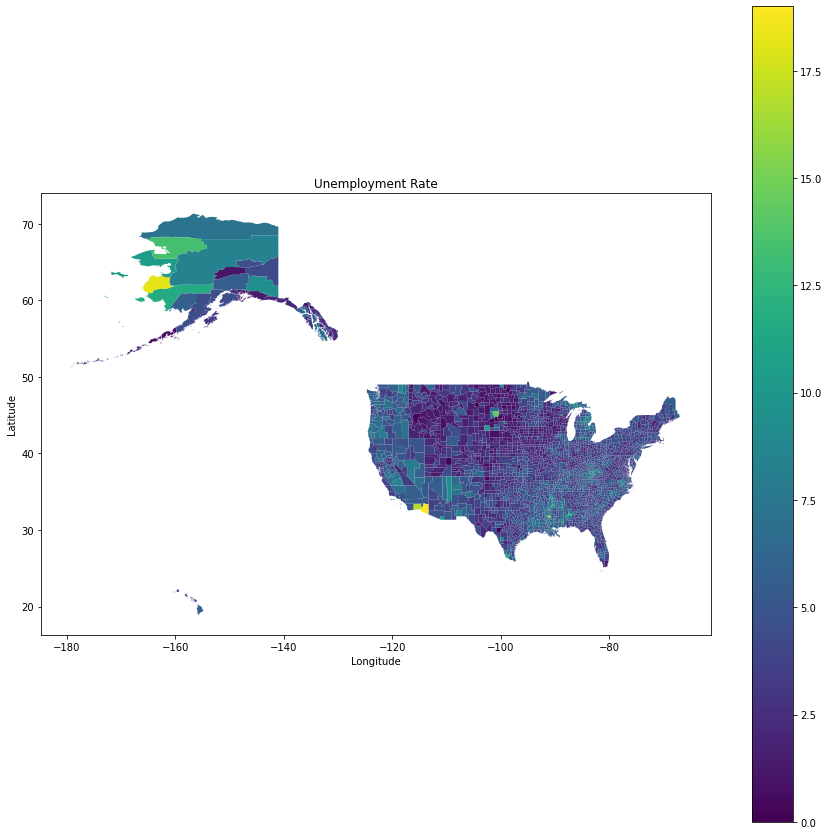

In [88]:
dem_gdf.plot(figsize=(15, 15), column='UNEMPRT_CY', legend=True)
plt.title('Unemployment Rate')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<AxesSubplot:ylabel='Frequency'>

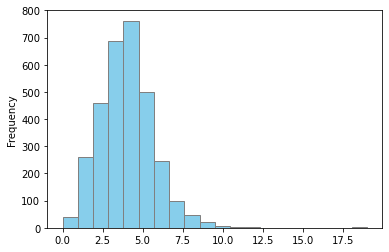

In [93]:
dem_gdf['UNEMPRT_CY'].plot.hist(bins=20, color='skyblue', edgecolor='grey')

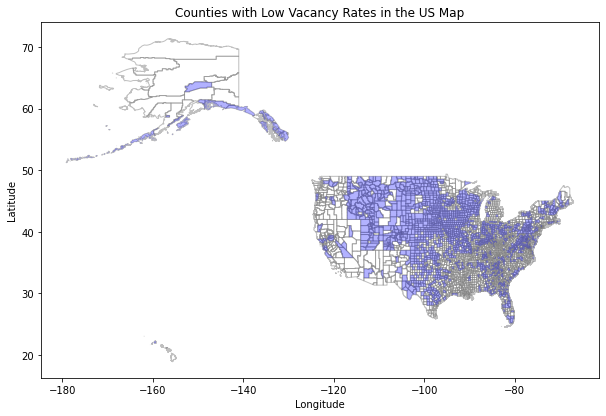

In [94]:
# Define regions with low unemployment as preferred
dem_gdf['focus_employ'] = dem_gdf['UNEMPRT_CY'] < dem_gdf['UNEMPRT_CY'].median()

# Filter locations
focus_employ= dem_gdf[dem_gdf['focus_employ']]

# Plot all US counties
fig, ax = plt.subplots(figsize=(10, 10))
dem_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.5)

# Plot locations with focus_employment in green
focus_employ.plot(ax=ax, color='blue', alpha=0.3)

plt.title('Counties with Low Unemployment Rates in the US Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Observations: 
- Northern-Central regions have the least unemployment
- West Coast Regions suffer from the highest unemployment

## Exploring Income Growth in the US

In [95]:
# float
dem_gdf['PCIGRWCYFY'] = dem_gdf.PCIGRWCYFY.apply(float)

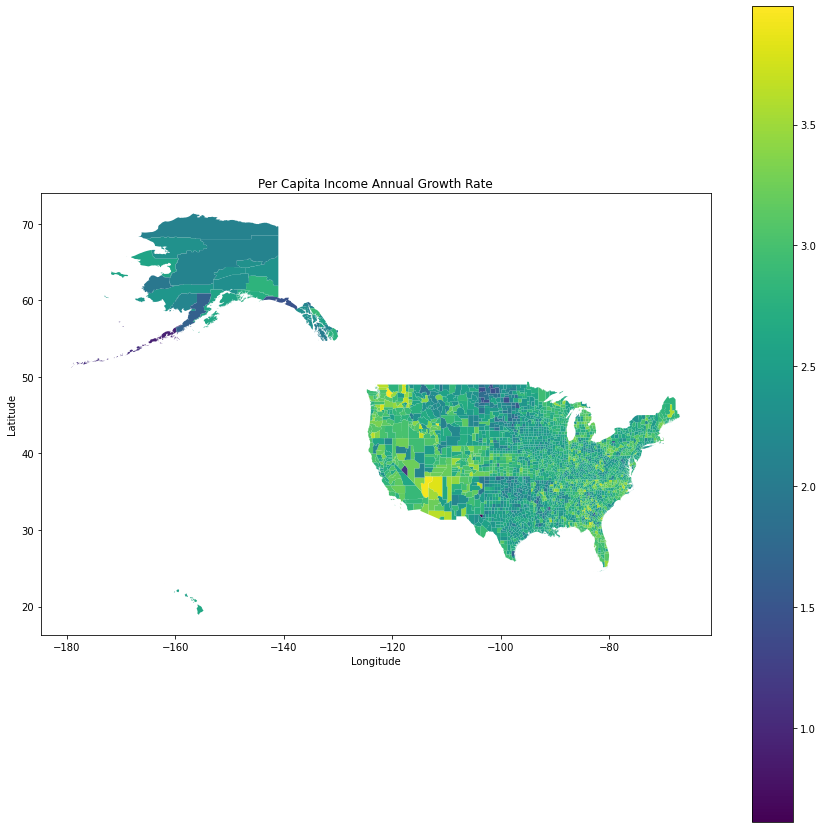

In [96]:
dem_gdf.plot(figsize=(15, 15), column='PCIGRWCYFY', legend=True)
plt.title('Per Capita Income Annual Growth Rate')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

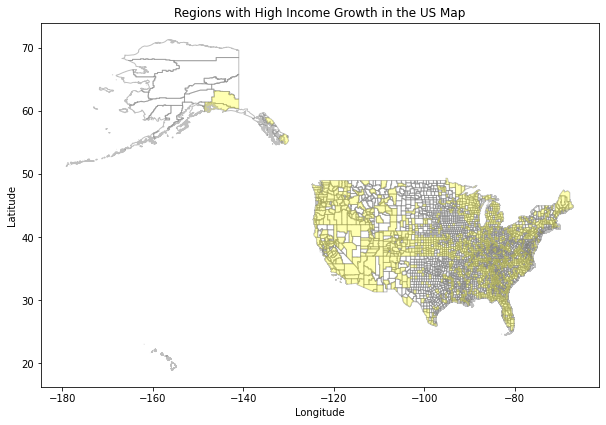

In [113]:
# Define regions with high income growth as preferred
dem_gdf['focus_income'] = dem_gdf['PCIGRWCYFY'] > dem_gdf['PCIGRWCYFY'].median()

# Filter locations
focus_income = dem_gdf[dem_gdf['focus_income']]

# Plot all US counties
fig, ax = plt.subplots(figsize=(10, 10))
dem_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.5)

# Plot locations with focus_employment in green
focus_income.plot(ax = ax, color= 'yellow', alpha=0.3)

plt.title('Regions with High Income Growth in the US Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Analysis

Provide a general outline of your analysis (in a markdown), and then document it step by step as you code the solution. Please make sure that we can reproduce your analysis by running your notebook. As before, a diagram describing your workflow would be helpful. Please also reflect on how your actual analysis steps were different compared to your project proposal - or state that you didn’t deviate from the initial plan.
(a combination of markdown and documented code cells)
(at least 500 words)

**Created Focus Layers**
- focus_climate
- focus_afford
- focus_vacancy
- focus_employ
- focus_income

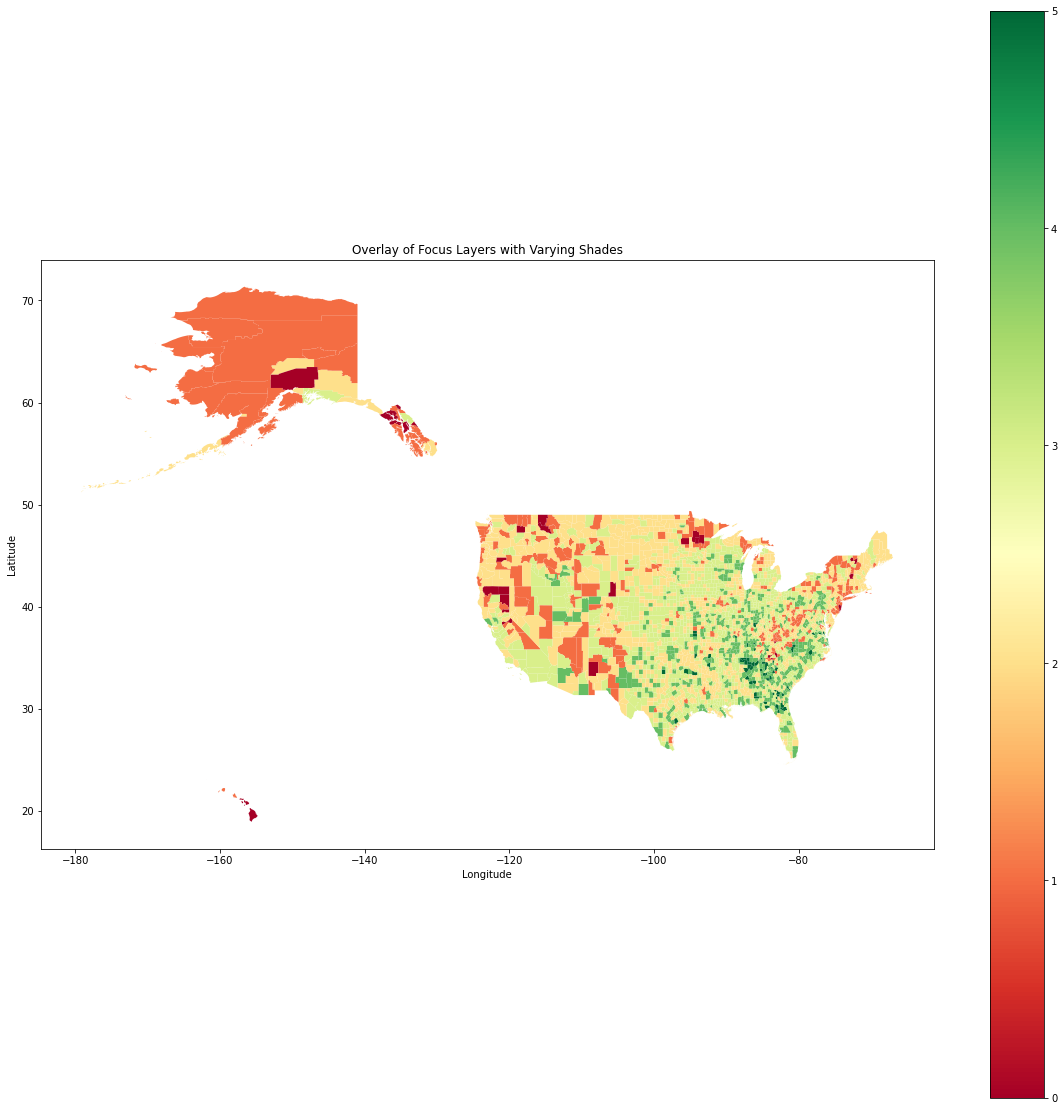

In [126]:
# Calculate overlap count for all rows at once
overlap_counts = dem_gdf[['focus_climate', 'focus_afford', 'focus_vacancy', 'focus_employ', 'focus_income']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(20,20))

# Plot polygons with different shades based on the number of true values
dem_gdf.plot(ax=ax, column=overlap_counts, cmap='RdYlGn', alpha= 1, legend=True)

plt.title('Overlay of Focus Layers with Varying Shades')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Summary of Results

Describe what you found, and why it is important; illustrate the findings with maps/charts reflecting your results.
(a combination of markdown and documented code cells)
(200 words)

## Discussion 

The discussion should include the following parts:
1) Discuss your findings with respect to the literature sources in section 3. What do the results mean in the context of what is already known? What is new? Does it validate what was found in literature? How do your results improve our understanding of the problem?

2) Of particular importance is a discussion of any trade-offs and decision points that you had to consider. This may include a discussion of any performance issues, width of buffers you applied, projections you chose, spatial operations you used, machine learning techniques, and other issues we discussed in class.
(this can be done as a markdown, at least 200 words)

## Conclusion and Future Work

Did you manage to completely answer your initial research question? If not, what additional data and additional analysis steps can you think of? Can your approach be extended to other areas or topics, and use additional datasets? How do you expect the results to be used and by whom? (a markdown cell, at least 200 words)